In [1]:
import pandas as pd
import os

%run "../util/funcionesEurostat.ipynb"

In [2]:
df = pd.read_csv("../data/raw/estat_lfsq_pganws_en.csv")

In [3]:
df.head()

,DATAFLOW,LAST UPDATE,freq,unit,sex,citizen,age,wstatus,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:LFSQ_PGANWS(1.0),15/03/24 11:00:00,Q,THS_PER,F,EU27_2020_FOR,Y15-19,ACT,AT,1998-Q1,NaN,u
1,ESTAT:LFSQ_PGANWS(1.0),15/03/24 11:00:00,Q,THS_PER,F,EU27_2020_FOR,Y15-19,ACT,AT,1999-Q1,NaN,u
2,ESTAT:LFSQ_PGANWS(1.0),15/03/24 11:00:00,Q,THS_PER,F,EU27_2020_FOR,Y15-19,ACT,AT,2000-Q1,NaN,u
3,ESTAT:LFSQ_PGANWS(1.0),15/03/24 11:00:00,Q,THS_PER,F,EU27_2020_FOR,Y15-19,ACT,AT,2000-Q2,NaN,u
4,ESTAT:LFSQ_PGANWS(1.0),15/03/24 11:00:00,Q,THS_PER,F,EU27_2020_FOR,Y15-19,ACT,AT,2001-Q1,NaN,u


eliminamos columnas inutiles

In [4]:
df = df.drop(['DATAFLOW','freq','unit','OBS_FLAG','LAST UPDATE'],axis=1)

cambiar Nan por ceros en OBS_VALUE

In [5]:
df['OBS_VALUE'] = df['OBS_VALUE'].fillna(0)
df['OBS_VALUE'] = df['OBS_VALUE'].round(1)


añdimos columnas con fechas año mes y dia

In [6]:
# Función para mapear los trimestres a meses específicos
def map_quarter_to_month(quarter):
    year, q = quarter.split('-Q')
    if q == '1':
        return f"{year}-03-01"
    elif q == '2':
        return f"{year}-06-01"
    elif q == '3':
        return f"{year}-09-01"
    elif q == '4':
        return f"{year}-12-01"
    else:
        return None

# Crear la nueva columna 'year_month' basada en la columna 'TIME_PERIOD'
df['year_month'] = df['TIME_PERIOD'].apply(map_quarter_to_month)

nos quedamos con los extranjeros activos

In [7]:
df_foreigners_act = df[(df['citizen']=='FOR') & (df['wstatus']=='ACT')]


,sex,citizen,age,wstatus,geo,TIME_PERIOD,OBS_VALUE,year_month
378374,F,FOR,Y15-19,ACT,AT,1998-Q1,9.5,1998-03-01
378375,F,FOR,Y15-19,ACT,AT,1999-Q1,7.3,1999-03-01
378376,F,FOR,Y15-19,ACT,AT,2000-Q1,9.7,2000-03-01
378377,F,FOR,Y15-19,ACT,AT,2000-Q2,8.8,2000-06-01
378378,F,FOR,Y15-19,ACT,AT,2001-Q1,7.7,2001-03-01
378379,F,FOR,Y15-19,ACT,AT,2002-Q1,7.6,2002-03-01
378380,F,FOR,Y15-19,ACT,AT,2003-Q1,6.5,2003-03-01
378381,F,FOR,Y15-19,ACT,AT,2003-Q2,4.6,2003-06-01
378382,F,FOR,Y15-19,ACT,AT,2003-Q3,5.6,2003-09-01
378383,F,FOR,Y15-19,ACT,AT,2003-Q4,6.2,2003-12-01


y con la fecha >= 2014

In [8]:
df_foreigners_act = df_foreigners_act[df_foreigners_act['year_month'] >= '2014-01-01']

UK lo quitamos de los paises?

In [10]:
countries = ['AT', 'BE', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES',
       'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LU', 'ME',
       'MT', 'NL', 'NO', 'PL', 'PT', 'RS', 'SE', 'SI', 'SK', 'UK', 'BA',
       'BG', 'LT', 'LV', 'MK', 'RO', 'TR']

creamos df por pais

In [11]:
# Crear un diccionario de DataFrames, uno por cada país
dfs_by_country = {}
for country in countries:
    dfs_by_country[country] = [df_foreigners_act[(df_foreigners_act['geo'] == country) & (df_foreigners_act['sex'] == 'M')],
                               df_foreigners_act[(df_foreigners_act['geo'] == country) & (df_foreigners_act['sex'] == 'F')]]

paises con df vacio

In [12]:
lista = encontrar_dfs_vacios(dfs_by_country)
# Imprimir los países con DataFrames vacíos
lista

['TR']

lo eliminamos

In [13]:
del dfs_by_country['TR']

recorremos el diccionario y añadimos una columna con el total de obs para cada fecha en cada dataframe

In [14]:
# Iterar sobre el diccionario
for country, dfs in dfs_by_country.items():
    # Iterar sobre los DataFrames para el país actual
    for df_gender in dfs:
        # Calcular el total de observaciones por fecha
        df_gender['total_obs_value'] = df_gender.groupby('year_month')['OBS_VALUE'].transform('sum')
        df_gender['total_obs_value'] = df_gender['total_obs_value'].round(1)
        

        

C:\Users\ricar\AppData\Local\Temp\ipykernel_14640\3652945003.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gender['total_obs_value'] = df_gender.groupby('year_month')['OBS_VALUE'].transform('sum')
C:\Users\ricar\AppData\Local\Temp\ipykernel_14640\3652945003.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gender['total_obs_value'] = df_gender['total_obs_value'].round(1)
C:\Users\ricar\AppData\Local\Temp\ipykernel_14640\3652945003.py:6: SettingWithCopyWarning: 
A value is trying to be set on a

Eliminamos dfs con mas del 50% de ceros

In [21]:
lista = encontrar_dfs_con_valores_cero(dfs_by_country)
print(lista)
for i in lista:
    del dfs_by_country[i]

[]


Genera dos archivos CSV por pais, uno con los datos masculinos y otro femeninos.
    los guarda en la carpeta pre-processed

In [16]:
salvar_dfs_preprocessed(dfs_by_country)


Genera un archivo CSV por pais, con los datos masculinos y totales(masculinos y femeninos).
    los guarda en la carpeta processed


In [17]:
salvar_df_processed(dfs_by_country)

C:\Users\ricar\AppData\Local\Temp\ipykernel_14640\284912122.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['year_month'] = pd.to_datetime(df1['year_month'])
C:\Users\ricar\AppData\Local\Temp\ipykernel_14640\284912122.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['year_month'] = pd.to_datetime(df2['year_month'])
C:\Users\ricar\AppData\Local\Temp\ipykernel_14640\284912122.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

completa la serie temporal mensual,y la sobreescribe

In [ ]:

# Llamar a la función con la ruta de la carpeta 'data/processed'
#completar_serie_temporal_mensual4('../data/processed')

Completa series temporales trimestrales incompletas en archivos CSV ubicados en un directorio
    de entrada y guarda las series completas en otro directorio.

In [18]:
completar_series_trimestrales('../data/processed')

generar una serie general

In [19]:
generar_serie_suma('../data/series')

C:\Users\ricar\AppData\Local\Temp\ipykernel_14640\2530184105.py:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  fechas_maximas = pd.Series()


ABRIR Y PINTAR UNA SERIE

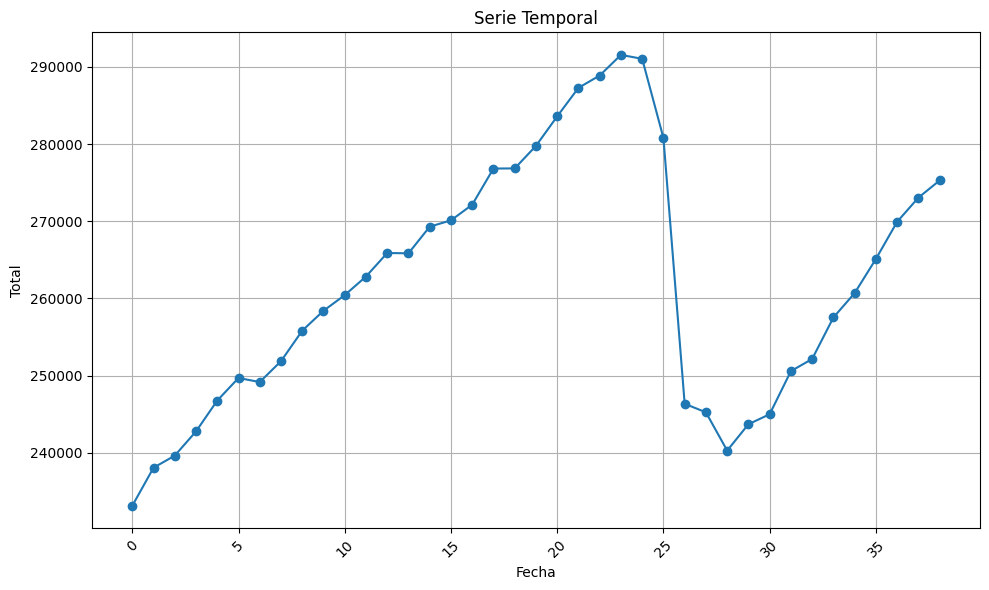

In [20]:
import matplotlib.pyplot as plt

# Leer el archivo CSV
df = pd.read_csv('../data/serie/serie_EU.csv')

# Convertir la columna 'year_month' a tipo datetime si es necesario
#df['year_month'] = pd.to_datetime(df['year_month'])

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))

# Trazar la serie temporal
plt.plot(df['total'], marker='o', linestyle='-')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Total')
plt.title('Serie Temporal')

# Rotar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.grid(True)
plt.tight_layout()